<a href="https://colab.research.google.com/github/Manar267/Heart-Failure-Prediction-Model/blob/main/Heart_Failure_Prediction_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

# New Section

In [4]:
df = pd.read_csv("/content/heart_failure_clinical_records_dataset.csv")

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
df.isnull().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [6]:
print((df.isnull().sum() / len(df)) * 100)

age                         0.0
anaemia                     0.0
creatinine_phosphokinase    0.0
diabetes                    0.0
ejection_fraction           0.0
high_blood_pressure         0.0
platelets                   0.0
serum_creatinine            0.0
serum_sodium                0.0
sex                         0.0
smoking                     0.0
time                        0.0
DEATH_EVENT                 0.0
dtype: float64


In [7]:
df.shape

(299, 13)

In [8]:
print(df.dtypes)

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


In [9]:
# Separate features (X) and target (y)
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

In [10]:
!pip install imblearn

In [11]:
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Shape of original training data:", X_train.shape)
print("Shape of resampled training data:", X_train_resampled.shape)

Shape of original training data: (269, 12)
Shape of resampled training data: (366, 12)


In [12]:
numerical_cols = X_train_resampled.select_dtypes(include=np.number).columns.tolist()
print("Numerical columns:", numerical_cols)

Numerical columns: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time']


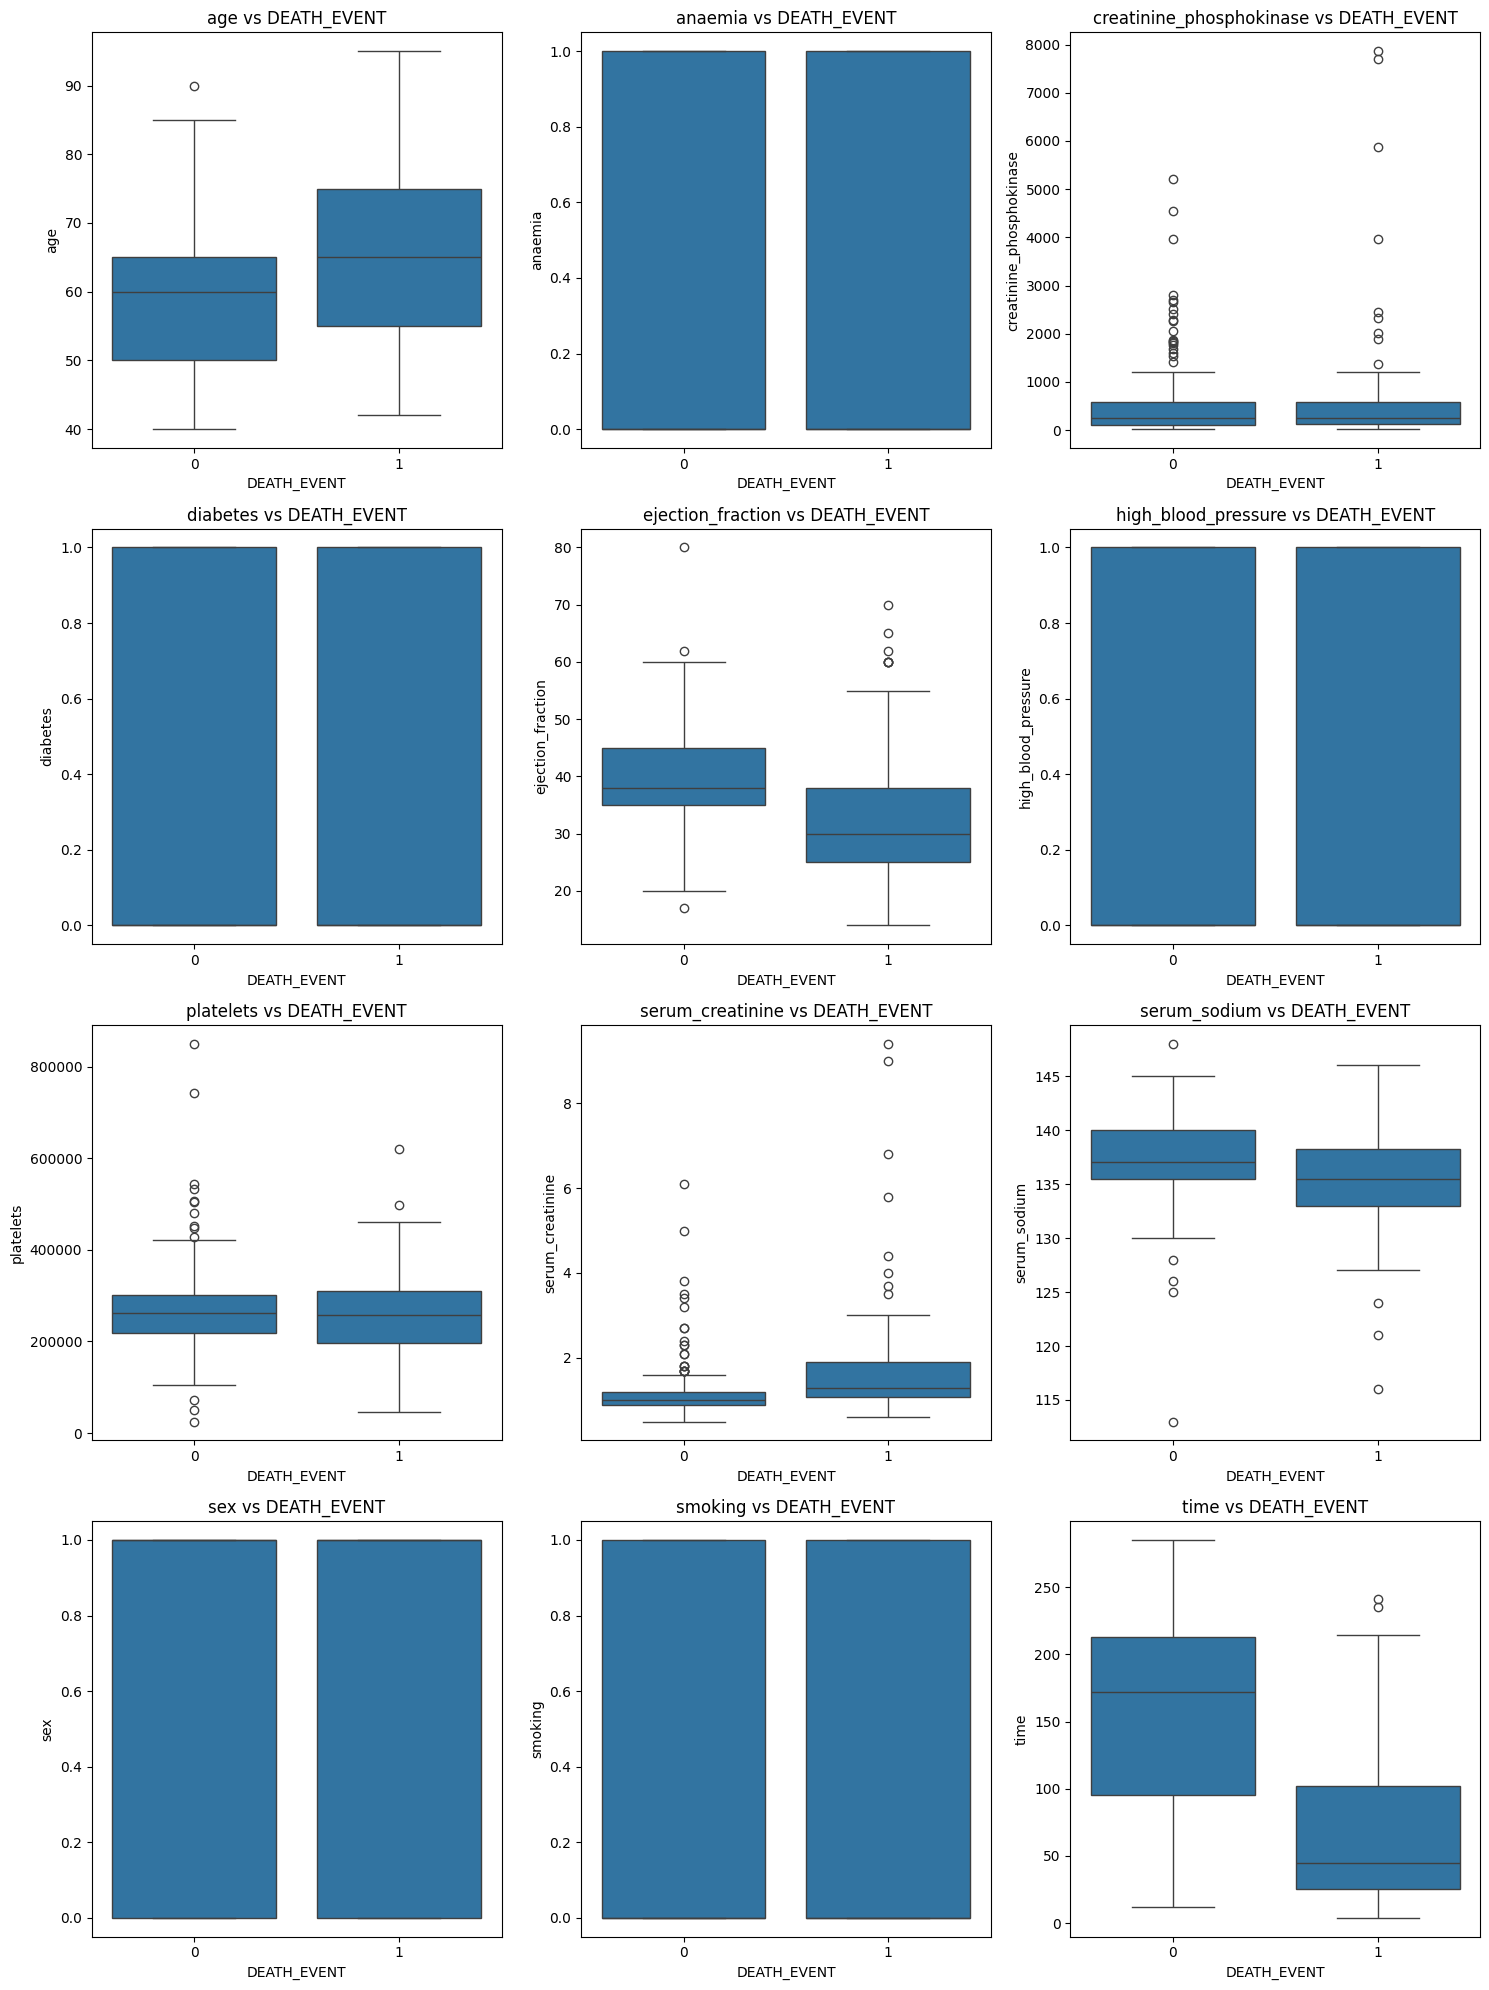

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plots for numerical features against the target variable
plt.figure(figsize=(15, 20)) # Increased figure size to accommodate more plots
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 3, i + 1) # Changed grid to 4x3
    sns.boxplot(x=y, y=X[col])
    plt.title(f'{col} vs DEATH_EVENT')
plt.tight_layout()
plt.show()



In [14]:
# Handle outliers in numerical features using IQR and capping

# Create copies to avoid modifying original dataframes
X_train_resampled_capped = X_train_resampled.copy()
X_test_capped = X_test.copy()

for col in numerical_cols:
    Q1 = X_train_resampled_capped[col].quantile(0.25)
    Q3 = X_train_resampled_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply capping to X_train_resampled_capped
    X_train_resampled_capped[col] = np.where(X_train_resampled_capped[col] < lower_bound, lower_bound, X_train_resampled_capped[col])
    X_train_resampled_capped[col] = np.where(X_train_resampled_capped[col] > upper_bound, upper_bound, X_train_resampled_capped[col])

    # Apply capping to X_test_capped using bounds calculated from the training data
    X_test_capped[col] = np.where(X_test_capped[col] < lower_bound, lower_bound, X_test_capped[col])
    X_test_capped[col] = np.where(X_test_capped[col] > upper_bound, upper_bound, X_test_capped[col])

print("Shape of X_train_resampled_capped:", X_train_resampled_capped.shape)
print("Shape of X_test_capped:", X_test_capped.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_resampled_capped: (366, 12)
Shape of X_test_capped: (30, 12)
Shape of y_train_resampled: (366,)
Shape of y_test: (30,)


# Modeling

In [15]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=22)

random_forest_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [None, 2, 4]
    }

In [16]:
# Perform grid search
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=random_forest_param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=22),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [None, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [17]:
# Best parameters and score
best_rf_params = grid_search_rf.best_params_
best_rf_score = grid_search_rf.best_score_

print(f"Best parameters for Random Forest: {best_rf_params}")
print(f"Best cross-validation accuracy for Random Forest: {best_rf_score}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy for Random Forest: 0.8585604472396927


In [18]:
# Evaluate the tuned model on the test set
best_rf_model = grid_search_rf.best_estimator_
import joblib

# حفظ أفضل موديل
joblib.dump(best_rf_model, "rf_model.pkl")



print("Model saved successfully!")

y_pred_tuned_rf = best_rf_model.predict(X_test)

Model saved successfully!


In [19]:
# Checking The Accuracy Of The Model
print(f"Tuned Random Forest Accuracy: {accuracy_score(y_test, y_pred_tuned_rf)*100:.2f}%")
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_tuned_rf))
import joblib
joblib.dump(grid_search_rf.best_estimator_,"grid_search_rf.best_estimator_.pkl")

Tuned Random Forest Accuracy: 96.67%
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



['grid_search_rf.best_estimator_.pkl']

In [20]:
# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
# Perform grid search
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [22]:
# Best parameters and score

best_dt_params = grid_search_dt.best_params_
best_dt_score = grid_search_dt.best_score_

print(f"Best parameters for Decision Tree: {best_dt_params}")
print(f"Best cross-validation accuracy for Decision Tree: {best_dt_score}")

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy for Decision Tree: 0.7916841369671559


In [23]:
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)

In [24]:
# Checking The Accuracy Of The Model
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)*100:.2f}%")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 83.33%
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        20
           1       0.78      0.70      0.74        10

    accuracy                           0.83        30
   macro avg       0.82      0.80      0.81        30
weighted avg       0.83      0.83      0.83        30



In [25]:
# Logistic Regression Model
lr_reg_model = LogisticRegression(random_state=22)

lr_reg_param_grid = {
    'penalty': ['l2', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

In [26]:
# Perform grid search
grid_search_lr = GridSearchCV(estimator=lr_reg_model, param_grid=lr_reg_param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=22),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000],
                         'penalty': ['l2', None], 'solver': ['lbfgs']},
             scoring='accuracy')

In [27]:
# Best parameters and score
best_lr_params = grid_search_lr.best_params_
best_lr_score = grid_search_lr.best_score_

print(f"Best parameters for Logistic Regression: {best_lr_params}")
print(f"Best cross-validation accuracy for Logistic Regression: {best_lr_score}")

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy for Logistic Regression: 0.8139762403913349


In [28]:
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

In [29]:
# Checking The Accuracy Of The Model
print(f"Logistic Regression Accuracy:, {accuracy_score(y_test, y_pred_lr)*100:.2f}%")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy:, 96.67%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [30]:
# XGBoost Model
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [31]:
# Perform grid search
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='accuracy')

In [32]:
# Best parameters and score
best_xgb_params = grid_search_xgb.best_params_
best_xgb_score = grid_search_xgb.best_score_

print(f"Best parameters for XGBoost: {best_xgb_params}")
print(f"Best cross-validation accuracy for XGBoost: {best_xgb_score}")

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy for XGBoost: 0.843675751222921


In [33]:
best_xgp_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgp_model.predict(X_test)

In [34]:
# Checking The Accuracy Of The Model
print(f"XGBoost Accuracy:, {accuracy_score(y_test, y_pred_xgb)*100:.2f}%")
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy:, 96.67%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [35]:
# SVM Model
svm_model = SVC(random_state=42)

svm_param_dist = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [36]:
# Perform randomized search
random_search_svm = RandomizedSearchCV(estimator=svm_model, param_distributions=svm_param_dist, n_iter=10, cv=2, scoring='accuracy', random_state=42, n_jobs=-1)
random_search_svm.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=SVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': [0.1, 1],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='accuracy')

In [37]:
# Best parameters and score
best_svm_params = random_search_svm.best_params_
best_svm_score = random_search_svm.best_score_

print(f"Best parameters for SVM (RandomizedSearchCV): {best_svm_params}")
print(f"Best cross-validation accuracy for SVM: {best_svm_score}")

Best parameters for SVM (RandomizedSearchCV): {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best cross-validation accuracy for SVM: 0.8029297954671089


In [38]:
# Evaluate best model
best_svm_model = random_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)

In [39]:
# Checking The Accuracy Of The Model
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm)*100:.2f}%")
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 96.67%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



# New Section

In [40]:
# Comparison
results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "XGBoost", "SVM"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_dt)*100,
        accuracy_score(y_test, y_pred_tuned_rf)*100,
        accuracy_score(y_test, y_pred_lr)*100,
        accuracy_score(y_test, y_pred_xgb)*100,
        accuracy_score(y_test, y_pred_svm)*100,
    ],

     "F1-Score": [
        f1_score(y_test, y_pred_dt)*100,
        f1_score(y_test, y_pred_tuned_rf)*100,
        f1_score(y_test, y_pred_lr)*100,
        f1_score(y_test, y_pred_xgb)*100,
        f1_score(y_test, y_pred_svm)*100,
    ]
})

print(results)

                 Model   Accuracy   F1-Score
0        Decision Tree  83.333333  73.684211
1        Random Forest  96.666667  95.238095
2  Logistic Regression  96.666667  95.238095
3              XGBoost  96.666667  95.238095
4                  SVM  96.666667  94.736842


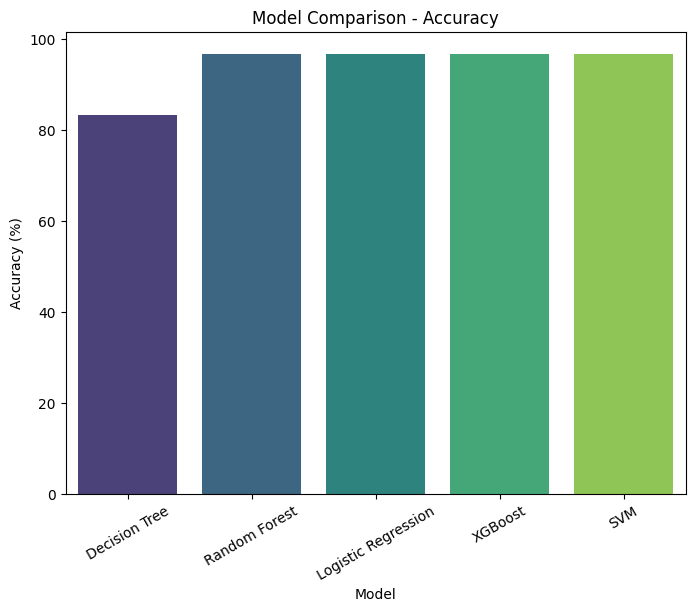

In [41]:
# Bar plot for Accuracy

plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="Accuracy", data=results, palette="viridis")
plt.title("Model Comparison - Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30)
plt.show()

In [42]:
!pip install gradio
!pip install joblib


In [43]:
import joblib
joblib.dump(grid_search_rf.best_estimator_, "grid_search_rf.best_estimator_")


['grid_search_rf.best_estimator_']

In [44]:

import gradio as gr
import joblib
import pandas as pd

#  الموديل اللي لسه حفظتيه
model = joblib.load("/content/grid_search_rf.best_estimator_.pkl")

# أعمدة الداتا  بالأسامي الصحيحة وبنفس الترتيب
feature_names = [
    "age",
    "anaemia",
    "creatinine_phosphokinase",
    "diabetes",
    "ejection_fraction",
    "high_blood_pressure",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "sex",
    "smoking",
    "time"
]

def predict_heart_failure(age, anaemia, creatinine_phosphokinase, diabetes,
                          ejection_fraction, high_blood_pressure,
                          platelets, serum_creatinine, serum_sodium,
                          sex, smoking, time):

    # حول اختيارات Yes/No و Male/Female لأرقام
    anaemia = 1 if anaemia == "Yes" else 0
    diabetes = 1 if diabetes == "Yes" else 0
    high_blood_pressure = 1 if high_blood_pressure == "Yes" else 0
    sex = 1 if sex == "Male" else 0
    smoking = 1 if smoking == "Yes" else 0

    # حول الأرقام لأنواع رقمية
    age = float(age)
    creatinine_phosphokinase = float(creatinine_phosphokinase)
    ejection_fraction = float(ejection_fraction)
    platelets = float(platelets)
    serum_creatinine = float(serum_creatinine)
    serum_sodium = float(serum_sodium)
    time = float(time)

    # جهّز DataFrame بنفس الأعمدة والترتيب
    row = [[age, anaemia, creatinine_phosphokinase, diabetes,
            ejection_fraction, high_blood_pressure,
            platelets, serum_creatinine, serum_sodium,
            sex, smoking, time]]

    X = pd.DataFrame(row, columns=feature_names)


    pred = model.predict(X)[0]

    # لو الموديل بيدعم الاحتمالات، نعرض الثقة
    proba_txt = ""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)[0][1]
        proba_txt = f" (prob={p:.2f})"

    return ("🚨 High risk of heart disease" if pred == 1 else "✅ Your results are normal") + proba_txt





with gr.Blocks() as demo:
    gr.Markdown("## 🫀 Heart Failure Prediction App")

    with gr.Row():
        age = gr.Number(label="Age")
        anaemia = gr.Radio(["Yes","No"], label="Anaemia")
        creatinine_phosphokinase = gr.Number(label="Creatinine Phosphokinase")
        diabetes = gr.Radio(["Yes","No"], label="Diabetes")
        ejection_fraction = gr.Number(label="Ejection Fraction")
        high_blood_pressure = gr.Radio(["Yes","No"], label="High Blood Pressure")

    with gr.Row():
        platelets = gr.Number(label="Platelets")
        serum_creatinine = gr.Number(label="Serum Creatinine")
        serum_sodium = gr.Number(label="Serum Sodium")
        sex = gr.Radio(["Male","Female"], label="Sex")
        smoking = gr.Radio(["Yes","No"], label="Smoking")
        time = gr.Number(label="Time (days)")

    btn = gr.Button("Predict")
    out = gr.Textbox(label="Result")

    btn.click(
        predict_heart_failure,
        inputs=[age, anaemia, creatinine_phosphokinase, diabetes,
                ejection_fraction, high_blood_pressure,
                platelets, serum_creatinine, serum_sodium,
                sex, smoking, time],
        outputs=out
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0bc99d51aa0a8f1654.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
